<a href="https://colab.research.google.com/github/Avijeetas/learning-machine-learning/blob/master/zomato%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



In [0]:
!kaggle datasets download himanshupoddar/zomato-bangalore-restaurants 

In [0]:
!unzip zomato-bangalore-restaurants.zip

In [0]:
!pip install --upgrade seaborn
!pip install --upgrade numpy

In [0]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import HeatMap
import folium
from tqdm import tqdm
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from gensim.models import word2vec
import nltk
%matplotlib inline
%tensorflow_version 1.x

In [0]:
df=pd.read_csv('zomato.csv')

#df['reviews_list']=df['reviews_list'].str.extract('(\d+)').astype(int)
#df.head()
df.info()



Columns description

    **url** contains the url of the restaurant in the zomato website

    **address** contains the address of the restaurant in Bengaluru

    **name** contains the name of the restaurant

    online_order whether online ordering is available in the restaurant or not

    **book_table** table book option available or not

    **rate** contains the overall rating of the restaurant out of 5

    **votes** contains total number of rating for the restaurant as of the above mentioned date

    **phone** contains the phone number of the restaurant

    **location** contains the neighborhood in which the restaurant is located

    **rest_type** restaurant type

    **dish_liked** dishes people liked in the restaurant

    **cuisines** food styles, separated by comma

    **approx_cost(for two people)** contains the approximate cost for meal for two people

    **reviews_list** list of tuples containing reviews for the restaurant, each tuple

    **menu_item** contains list of menus available in the restaurant

    listed_in(type) type of meal

    listed_in(city) contains the neighborhood in which the restaurant is listed



Text(0.5, 0, 'No of outlets')

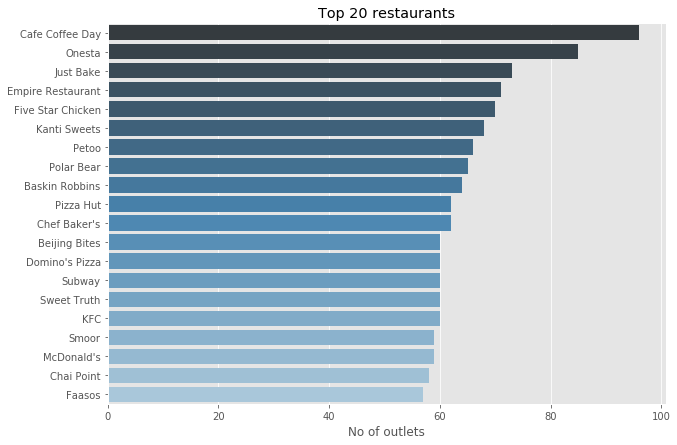

In [7]:
plt.figure(figsize=(10,7))
top=df['name'].value_counts()[:20]
sns.barplot(x=top,y=top.index,palette='Blues_d')
plt.title('Top 20 restaurants')
plt.xlabel('No of outlets')


In [63]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
configure_plotly_browser_state()


In [73]:

%matplotlib inline
py.init_notebook_mode(connected=True)

o_order=df['online_order'].value_counts()
colors=['Red','Blue']

fig=go.Figure(data=[go.Pie(labels=o_order.index,values=o_order,textinfo="value",marker=dict(colors=colors,line=dict(color='#000000',width=2)))])
fig.show()

In [61]:
o_order=df['book_table'].value_counts()
colors=['Cyan','Orange']

fig=go.Figure(data=[go.Pie(labels=o_order.index,values=o_order)])
fig.show()

<Figure size 432x360 with 0 Axes>

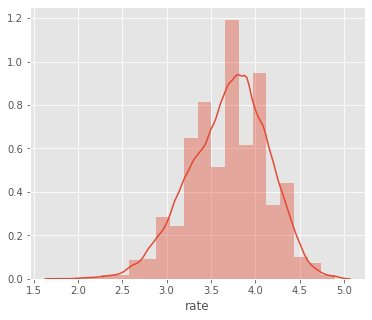

In [23]:
plt.figure(figsize=(6,5))
rating=df['rate'].dropna().apply(lambda x : float(x.split('/')[0]) if (len(x)>3)  else np.nan ).dropna()
sns.distplot(rating,bins=20)


In [0]:
cost_ty=df[['rate','approx_cost(for two people)','online_order']].dropna()

cost_ty['rate']=cost_ty['rate'].apply(lambda x : float(x.split('/')[0]) if len(x)>3 else 0)
cost_ty['approx_cost(for two people)']=cost_ty['approx_cost(for two people)'].apply(lambda x : int(x.replace(',','')))

<Figure size 720x504 with 0 Axes>

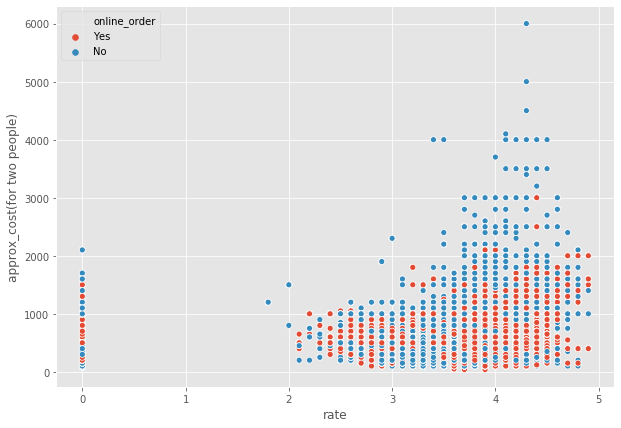

In [36]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='rate',y='approx_cost(for two people)',hue='online_order',data=cost_dist)
plt.show()

<Figure size 720x432 with 0 Axes>

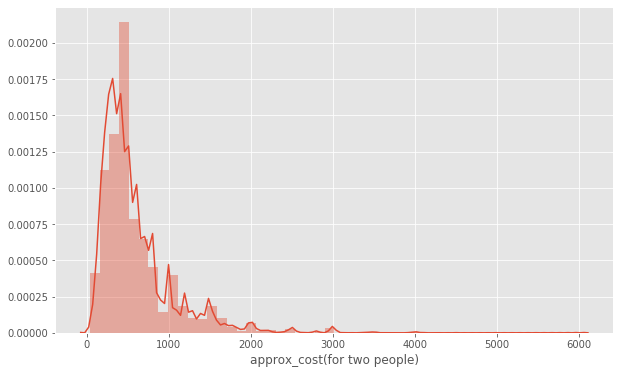

In [40]:
plt.figure(figsize=(10,6))
sns.distplot(cost_ty['approx_cost(for two people)'])
plt.show()

In [86]:
yes=df[df['online_order']=="Yes"]['votes']
data1=go.Box(y=yes,name="accepting online orders",
             marker=dict(
                 color='rgb(122,122,2)',
             ))


no=df[df['online_order']=="No"]['votes']
data2=go.Box(y=no,name="Not accepting online orders",
             marker=dict(
                 color='rgb(122,2,122)',
             ))

data=[data1,data2]
layout=go.Layout(
    title='Votes', width=800,height=600
)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)

'''


    Yes,you can observe that median number of votes for both categories vary.
    Restaurants accepting online orders tend to get more votes from customers as there is a rating option poping up after each order through zomato application.

'''

cost=go.Box(y=df['approx_cost(for two people)'],name ='online_orders',
            marker=dict(
                color='blue',
            )
  )

data=[cost]
layout=go.Layout(
    title='cost', width=500,height=600
)
fig=go.Figure(data=data,layout=layout)
py.iplot(fig)


'\n\n\n    Yes,you can observe that median number of votes for both categories vary.\n    Restaurants accepting online orders tend to get more votes from customers as there is a rating option poping up after each order through zomato application.\n\n'

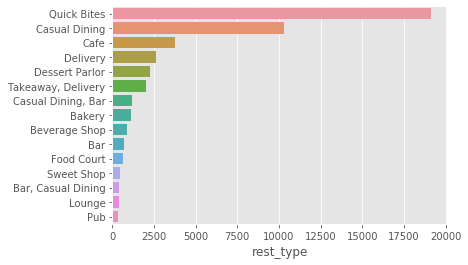

In [77]:

rest_typ=df['rest_type'].value_counts()[:15]
sns.barplot(rest_typ,rest_typ.index)


In [92]:
cost_ty=df[['rate','approx_cost(for two people)','location','name','rest_type']].dropna()
cost_ty['rate']=cost_ty['rate'].apply(lambda x: float(x.split('/')[0]) if len(x)>3 else 0)
cost_ty['approx_cost(for two people)']=cost_ty['approx_cost(for two people)'].apply(lambda x: int(x.replace(',','')))


In [97]:

def location_item(location, rst):
  bud=cost_ty[(cost_ty['approx_cost(for two people)']<=400) &( cost_ty['location']==location) &
              (cost_ty['rate']>4) & (cost_ty['rest_type']==rst)]
  return bud['name'].unique()

In [101]:
location_item('BTM','Quick Bites')

array(['Swadista Aahar', 'Litti Twist', 'The Shawarma Shop', 'Gorbandh',
       'Yum In My Tum', 'Chaatimes', "Muthashy's", 'Swad Punjab Da',
       "Domino's Pizza", 'Roti Wala', 'Andhra Kitchen'], dtype=object)

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Top 20 locations')

Text(0.5, 0, 'Count')

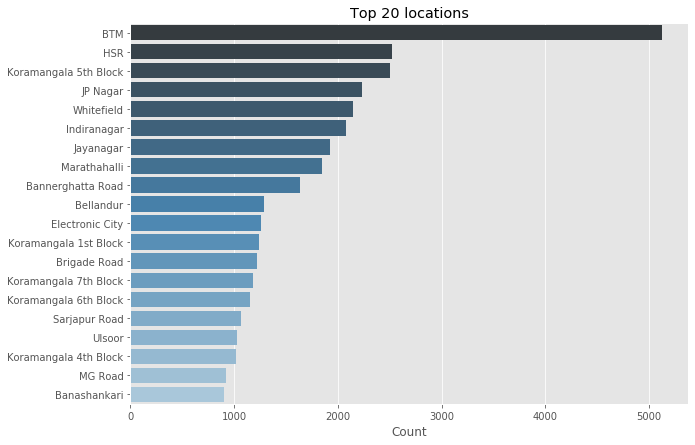

In [102]:
plt.figure(figsize=(10,7))
top=df['location'].value_counts()[:20]
sns.barplot(x=top,y=top.index,palette='Blues_d')
plt.title('Top 20 locations')
plt.xlabel('Count')


In [103]:
df_1=df.groupby(['location','cuisines']).agg('count')
data=df_1.sort_values(['url'],ascending=False).groupby(['location'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [104]:
data.head(10)

level_0           location               cuisines  count
0        0                BTM  North Indian, Chinese    379
1        0                BTM           North Indian    340
2        0                BTM                Biryani    120
3        1       Banashankari           South Indian     86
4        1       Banashankari  North Indian, Chinese     61
5        1       Banashankari           North Indian     36
6        2          Banaswadi           South Indian     37
7        2          Banaswadi  North Indian, Chinese     24
8        2          Banaswadi                Biryani     23
9        3  Bannerghatta Road  North Indian, Chinese    130

In [107]:
locations=pd.DataFrame({"Name":df['location'].unique()})
locations['Name']=locations['Name'].apply(lambda x : "Bangalore "+str(x))
lat_lon=[]

geolocator=Nominatim(user_agent="app")
for loc in locations["Name"]:
  loc=geolocator.geocode(loc)
  if loc is None:
    lat_lon.append(np.nan)
  else:
    geo=(loc.latitude,loc.longitude)
    lat_lon.append(geo)
locations['geo_loc']=lat_lon
locations.to_csv('locations.csv',index=False)

In [108]:
locations["Name"]=locations["Name"].apply(lambda x : x.replace("Bangalore","")[1:])
locations.head(10)

Name                         geo_loc
0          Banashankari         (12.9152208, 77.573598)
1          Basavanagudi        (12.9417261, 77.5755021)
2           Mysore Road        (12.9104361, 77.4836681)
3             Jayanagar        (12.9292731, 77.5824229)
4    Kumaraswamy Layout  (12.9068169, 77.5635247362134)
5  Rajarajeshwari Nagar        (12.9274278, 77.5153722)
6           Vijay Nagar                             NaN
7           Uttarahalli        (12.9055682, 77.5455438)
8              JP Nagar        (12.9072515, 77.5782713)
9                South         (12.9791198, 77.5912997)

In [117]:
rest_loc=pd.DataFrame(df['location'].value_counts().reset_index())

rest_loc.columns=['Name','count']
rest_loc=rest_loc.merge(locations,on='Name',how='left').dropna()
rest_loc['count'].max()
rest_loc

5124

Name  count                          geo_loc
0                     BTM   5124  (12.91127585, 77.6045654343118)
1                     HSR   2523  (12.91445305, 77.6426938363703)
2   Koramangala 5th Block   2504         (13.2923988, 77.7519261)
3                JP Nagar   2235         (12.9072515, 77.5782713)
4              Whitefield   2144         (12.9696365, 77.7497448)
..                    ...    ...                              ...
86                Kengeri      9         (12.9176571, 77.4837568)
89              Yelahanka      6         (13.1006982, 77.5963454)
90                 Jakkur      3         (13.0784743, 77.6068938)
91   Rajarajeshwari Nagar      2         (12.9274278, 77.5153722)
92                 Peenya      1         (13.0329419, 77.5273253)

[83 rows x 3 columns]

In [125]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map


lat,lon=zip(*np.array(rest_loc['geo_loc']))
rest_loc['lat']=lat
rest_loc['lon']=lon
basemap=generateBaseMap()
HeatMap(rest_loc[['lat','lon','count']].values.tolist(),zoom=12,radius=15).add_to(basemap)

TypeError: ignored

In [126]:
def produce_data(col,name):
    data= pd.DataFrame(df[df[col]==name].groupby(['location'],as_index=False)['url'].agg('count'))
    data.columns=['Name','count']
    print(data.head())
    data=data.merge(locations,on="Name",how='left').dropna()
    data['lan'],data['lon']=zip(*data['geo_loc'].values)
    return data.drop(['geo_loc'],axis=1)

In [127]:


North_India=produce_data('cuisines','North Indian')



                Name  count
0                BTM    340
1       Banashankari     36
2          Banaswadi     12
3  Bannerghatta Road     75
4       Basavanagudi     21


In [128]:
basemap=generateBaseMap()
HeatMap(North_India[['lan','lon','count']].values.tolist(),zoom=20,radius=15).add_to(basemap)
basemap


TypeError: ignored

In [131]:
df_1=df.groupby(['rest_type','name']).agg('count')
datas=df_1.sort_values(['url'],ascending=False).groupby(['rest_type'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})


In [132]:


mapbox_access_token="pk.eyJ1Ijoic2hhaHVsZXMiLCJhIjoiY2p4ZTE5NGloMDc2YjNyczBhcDBnZnA5aCJ9.psBECQ2nub0o25PgHcU88w"



In [133]:


casual=datas[datas['rest_type']=='Casual Dining']
casual



level_0      rest_type                name  count
59       27  Casual Dining   Empire Restaurant     58
60       27  Casual Dining       Beijing Bites     48
61       27  Casual Dining  Mani's Dum Biryani     47

In [135]:
def produce_chains(name):
    data_chain=pd.DataFrame(df[df["name"]==name]['location'].value_counts().reset_index())
    data_chain.columns=['Name','count']
    data_chain=data_chain.merge(locations,on="Name",how="left").dropna()
    data_chain['lan'],data_chain['lon']=zip(*data_chain['geo_loc'].values)
    return data_chain[['Name','count','lan','lon']]
def produce_trace(data_chain,name):
        data_chain['text']=data_chain['Name']+'<br>'+data_chain['count'].astype(str)
        trace =  go.Scattermapbox(
           
                lat=data_chain['lan'],
                lon=data_chain['lon'],
                mode='markers',
                marker=go.scattermapbox.Marker(
                    size=data_chain['count']*4
                ),
                text=data_chain['text'],name=name
            )
        
        return trace

data=[] 
for row in casual['name']:
    data_chain=produce_chains(row) 
    trace_0=produce_trace(data_chain,row)
    data.append(trace_0)



layout = go.Layout(title="Casual Dining Restaurant chains locations around Banglore",
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,style="streets",
        center=dict(
            lat=12.96,
            lon=77.59
        ),
        pitch=0,
        zoom=10
    ),
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Montreal Mapbox')



In [136]:
quick=datas[datas['rest_type']=='Quick Bites']
quick 

data=[]  
for row in quick['name']:
    data_chain=produce_chains(row) 
    trace_0=produce_trace(data_chain,row)
    data.append(trace_0)



layout = go.Layout(title="Quick Bites Restaurant chains locations around Banglore",
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,style="streets",
        center=dict(
            lat=12.96,
            lon=77.59
        ),
        pitch=0,
        zoom=10
    ),
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Montreal Mapbox')

level_0    rest_type               name  count
179       78  Quick Bites  Five Star Chicken     69
180       78  Quick Bites     Domino's Pizza     60
181       78  Quick Bites         McDonald's     59